In [373]:

import urbanpy as up
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import time
import os
from tqdm.auto import tqdm
from unidecode import unidecode

In [41]:
df = pd.read_excel('outputs/encuesta_limpieza_en_proceso_22_02_23.xlsx', index_col=0)

In [42]:
df.shape

(1813, 101)

## Geocoding

Convertir direcciones a coordenadas (latitude, longitude)

#### Helper functions

In [413]:
def clean_address(address):
    remove_list = ['Pto De Ref', 'Entre', 'Detras De', 'Cruce Con', 'A La Espalda De La  Angamos', 'Con ', '/']
    if isinstance(address, str):
        for seps in remove_list:
            if seps in address:
                address = address.split(seps)[0].strip()
    
    return address

def geocode(query, viewbox):
    params = {'q': query,
              'viewbox': viewbox,
              'limit': 1,
              'format': 'json',
              'email': 'claudio.rtega2701@gmail.com'}
    
    headers = {'user-agent': 'inmigrantes-vulnerables-app'}

    response = requests.get('https://nominatim.openstreetmap.org/search', params=params, headers=headers)
    data = response.json()
    
    time.sleep(1) # No heavy uses (an absolute maximum of 1 request per second).
    
    return data

def geocode_df(df, query_col, viewbox, return_gdf=False):
    geocodes = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        data = geocode(row[query_col], viewbox)
        geocodes.append((index, data))

    geocodes_df = pd.DataFrame.from_records({i: data[0] for i, data in geocodes if len(data) > 0}).T
    
    if return_gdf:
        new_df = df.merge(geocodes_df[['lat', 'lon']], how='left', left_index=True, right_index=True)
        gdf = gpd.GeoDataFrame(new_df, crs='EPSG:4326', geometry=gpd.points_from_xy(new_df['lon'], new_df['lat']))
        return gdf
    else:
        return geocodes_df

###  Subset donde tipo de via es una de las opciones predeterminadas

In [49]:
# Columnas relacionadas a la ubicacion geografica
df.columns[4:12]

Index(['Provincia donde vive', 'Distrito donde vive',
       'Tipo de ubicacion: Manzana (Mz), Lote, Urbanizacion (urb) y/o Etapa.',
       'Tipo de vía', 'Especifica otro tipo de via', 'Nombre de la vía',
       'Número de cuadra', 'Número de puerta de la vivienda'],
      dtype='object')

In [255]:
address_cols = ['Provincia donde vive', 'Distrito donde vive', 
                'Tipo de ubicacion: Manzana (Mz), Lote, Urbanizacion (urb) y/o Etapa.',
                'Tipo de vía', 'Especifica otro tipo de via', 'Nombre de la vía',
                'Número de cuadra', 'Número de puerta de la vivienda']

new_address_cols = ['provincia_clean', 'distrito_clean', 
                'tipo_ubicacion_clean', 'tipo_via_clean', 'otro_tipo_via_clean', 'nombre_via_clean',
                'num_cuadra_clean', 'num_puerta_clean']

In [250]:
# Check missing values
df[address_cols].isna().sum()

Provincia donde vive                                                       0
Distrito donde vive                                                       30
Tipo de ubicacion: Manzana (Mz), Lote, Urbanizacion (urb) y/o Etapa.     418
Tipo de vía                                                             1171
Especifica otro tipo de via                                             1677
Nombre de la vía                                                         990
Número de cuadra                                                        1615
Número de puerta de la vivienda                                         1279
dtype: int64

In [251]:
# Check road name values
df['Nombre de la vía'].notna().sum()

823

In [252]:
# For road name values, check street/house number missing values
df[df['Nombre de la vía'].notna()][['Número de cuadra', 'Número de puerta de la vivienda']].isna().sum()

Número de cuadra                   636
Número de puerta de la vivienda    415
dtype: int64

In [277]:
def clean_df_string(col):
    clean = (col
             .apply(lambda x: int(x) if (type(x) == float) and pd.notna(x) else x)
             .fillna('') # Replace nan with emptry string
             .astype(str)
             .str.lower() # Lower all strings
             .apply(unidecode) # Remove all accents and special characters
             .str.replace(r"[^a-zA-Z0-9 ]", " ", regex=True) # Remove any non-alpanumeric or space character 
             .str.replace(r"[ ]+", " ", regex=True) # Reduce multiple spaces to one
             .str.strip() # Remove spaces at the start and end of the strings
            )
    return clean

In [278]:
for col, new_col in zip(address_cols, new_address_cols):
    df[new_col] = clean_df_string(df[col])

In [279]:
df[new_address_cols]

,provincia_clean,distrito_clean,tipo_ubicacion_clean,tipo_via_clean,otro_tipo_via_clean,nombre_via_clean,num_cuadra_clean,num_puerta_clean
0,chincha,pueblo nuevo,aahh nuevo chincha mz j lote 1,,asentamiento humano,chincha,0 0,160122 0
1,chincha,chincha alta,upis san agustin g 32,,upis,san agustin,4 0,32 0
2,chincha,pueblo nuevo,grocio prado,avenida,,grocio prado,3 0,398 0
3,ica,parcona,av avomayo 254,avenida,,,,
4,pisco,pisco,,calle,,leticia almirante miguel grau,,
...,...,...,...,...,...,...,...,...
1809,pisco,pisco,urb renacer lote 53,,,,,
1810,pisco,,urb renacer,calle,,106,,1706 0
1811,pisco,pisco,,calle,,cede monte,,559 0
1812,pisco,san andres,,calle,,miraflores,,470 0


In [280]:
new_address_cols

['provincia_clean',
 'distrito_clean',
 'tipo_ubicacion_clean',
 'tipo_via_clean',
 'otro_tipo_via_clean',
 'nombre_via_clean',
 'num_cuadra_clean',
 'num_puerta_clean']

In [351]:
new_address_cols_ordered = ['num_puerta_clean', 'num_cuadra_clean', 
                            'tipo_ubicacion_clean', 'tipo_via_clean', 
                            'nombre_via_clean', 'otro_tipo_via_clean']
                            
adm_region_cols = ['distrito_clean', 'provincia_clean']

In [352]:
df[adm_region_cols]

,distrito_clean,provincia_clean
0,pueblo nuevo,chincha
1,chincha alta,chincha
2,pueblo nuevo,chincha
3,parcona,ica
4,pisco,pisco
...,...,...
1809,pisco,pisco
1810,,pisco
1811,pisco,pisco
1812,san andres,pisco


In [381]:
df['nominatim_query'] = (df[new_address_cols_ordered].apply(" ".join, axis=1)
    .str.replace('[ ][0 ]*', ' ', regex=True) # Remove "0" that dont make sense alone
    .str.replace(r"[ ]+", " ", regex=True) # Reduce multiple spaces to one
    .str.strip() # Remove spaces at the start and end of the strings
)

(<AxesSubplot: >,
 count    1813.000000
 mean       34.682846
 std        16.041830
 min         0.000000
 25%        24.000000
 50%        31.000000
 75%        42.000000
 max       120.000000
 Name: nominatim_query, dtype: float64)

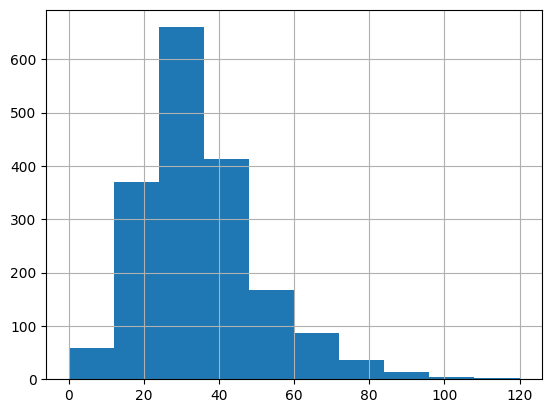

In [382]:
df['nominatim_query'].str.len().hist(), df['nominatim_query'].str.len().describe(), 

In [383]:
df_not_empty_query = df[df['nominatim_query'].str.len() > 0]

In [384]:
# Add administrative region information
df_not_empty_query.loc[:, 'nominatim_query_full'] = (df_not_empty_query.loc[:, ['nominatim_query'] + adm_region_cols]
    .apply(", ".join, axis=1)
    .str.replace(r"[ ]+", " ", regex=True) # Reduce multiple spaces to one
    .str.strip() # Remove spaces at the start and end of the strings
)

/tmp/ipykernel_16617/3439803901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_empty_query.loc[:, 'nominatim_query_full'] = (df_not_empty_query.loc[:, ['nominatim_query'] + adm_region_cols]


In [385]:
df_not_empty_query.loc[:, 'nominatim_query_full'].tolist()

['160122 aahh nuevo chincha mz j lote 1 chincha asentamiento humano, pueblo nuevo, chincha',
 '32 4 upis san agustin g 32 san agustin upis, chincha alta, chincha',
 '398 3 grocio prado avenida grocio prado, pueblo nuevo, chincha',
 'av avomayo 254 avenida, parcona, ica',
 'calle leticia almirante miguel grau, pisco, pisco',
 'yazta urb piedra de buenas vista, los aquijes, ica',
 '320 urb bolivia 320, san andres, pisco',
 '155 1 avenida alfoso ugarte, pueblo nuevo, chincha',
 '127 1 avenida america, chincha alta, chincha',
 'sector la esperanza mz 42 lote 43 calle simon bolivar, pisco, pisco',
 '0 mz p lote 22 avenida san agustin, chincha alta, chincha',
 '510 calle buenos aires, san andres, pisco',
 '0 pasaje el olivar s n olivar pasaje, chincha alta, chincha',
 '340 3 calle san miguel, pisco, pisco',
 'centro poblado las americas al frente de la polleria chicho calle jose balta, san andres, pisco',
 '90602 9 avenida av panamerica sur cercado chincha alta, chincha alta, chincha',
 'urb

<AxesSubplot: >

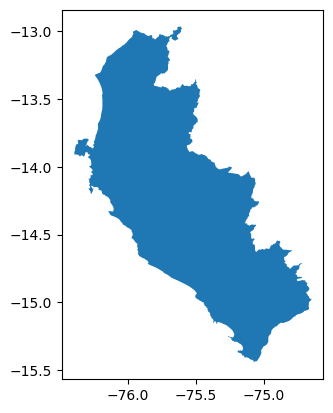

In [372]:
# Get Ica deparment administrative region polygon for query
ica = up.download.nominatim_osm('Ica, Peru')
ica.plot()

In [ ]:
Returns a tuple containing ``minx``, ``miny``, ``maxx``, ``maxy``

In [ ]:
ica.total_bounds

In [404]:
viewbox = ", ".join(ica.total_bounds.astype(str))

In [405]:
viewbox

'-76.3983632, -15.4437789, -74.6462412, -12.9649334'

In [415]:
output_fn = 'outputs/geocodes_ALL.geojson'
## Expensive query run only if file doesnt exist
if os.path.exists(output_fn):
    gdf = gpd.read_file(output_fn)
else:
    gdf = geocode_df(df_not_empty_query, 'nominatim_query_full', viewbox, return_gdf=True)
    gdf.to_file(output_fn, driver='GeoJSON')

  0%|          | 0/1792 [00:00<?, ?it/s]

In [435]:
gdf[gdf.geometry.isna()]

,Nombre del encuestador,Fecha de la entrevista,Nombre de la persona entrevistada,Télefono de la persona entrevistada,Provincia donde vive,Distrito donde vive,"Tipo de ubicacion: Manzana (Mz), Lote, Urbanizacion (urb) y/o Etapa.",Tipo de vía,Especifica otro tipo de via,Nombre de la vía,...,tipo_via_clean,otro_tipo_via_clean,nombre_via_clean,num_cuadra_clean,num_puerta_clean,nominatim_query,nominatim_query_full,lat,lon,geometry


In [424]:
gdf['lat'].isna().sum()

1652

In [433]:
gdf.shape

(1792, 114)

In [440]:
gdf['nominatim_query_full'].values.tolist()

['160122 aahh nuevo chincha mz j lote 1 chincha asentamiento humano, pueblo nuevo, chincha',
 '32 4 upis san agustin g 32 san agustin upis, chincha alta, chincha',
 '398 3 grocio prado avenida grocio prado, pueblo nuevo, chincha',
 'av avomayo 254 avenida, parcona, ica',
 'calle leticia almirante miguel grau, pisco, pisco',
 'yazta urb piedra de buenas vista, los aquijes, ica',
 '320 urb bolivia 320, san andres, pisco',
 '155 1 avenida alfoso ugarte, pueblo nuevo, chincha',
 '127 1 avenida america, chincha alta, chincha',
 'sector la esperanza mz 42 lote 43 calle simon bolivar, pisco, pisco',
 '0 mz p lote 22 avenida san agustin, chincha alta, chincha',
 '510 calle buenos aires, san andres, pisco',
 '0 pasaje el olivar s n olivar pasaje, chincha alta, chincha',
 '340 3 calle san miguel, pisco, pisco',
 'centro poblado las americas al frente de la polleria chicho calle jose balta, san andres, pisco',
 '90602 9 avenida av panamerica sur cercado chincha alta, chincha alta, chincha',
 'urb

In [462]:
gdf[gdf['lat'].notna()].drop('geometry', axis=1).to_excel('outputs/datos_georef.xlsx')

In [442]:
import contextily as cx

In [443]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

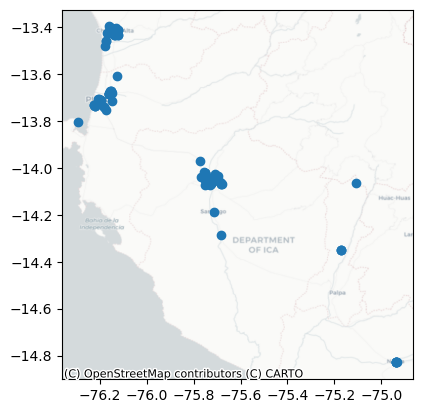

In [444]:
ax = gdf.plot()
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=gdf.crs)

In [452]:
gdf.geometry.notna().sum()

/tmp/ipykernel_16617/2014169041.py:1: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  gdf.geometry.notna().sum()


1792

In [458]:
map_ = gdf.loc[gdf.lat.notna(), ['nominatim_query_full','geometry']].explore()

In [459]:
map_.save("encuestas_georeferenciadas.html")

In [245]:
df['tipo_ubicacion_clean'] = clean_df_string(df['Tipo de ubicacion: Manzana (Mz), Lote, Urbanizacion (urb) y/o Etapa.'])


In [246]:
df['tipo_ubicacion_clean'].sort_values().unique().shape

(1316,)

In [59]:
df['Tipo de vía'].unique()

array(['Otro, especificar', 'AV (Avenida)', 'CA (Calle)',
       'No cuenta con información', nan, 'AL (Alameda)',
       'PRLG (Prolongación)', 'JR (Jirón)'], dtype=object)

In [244]:
df['Tipo de vía'] = df['Tipo de vía'].replace({
    'AV (Avenida)':'Avenida', 'CA (Calle)':'Calle', 'AL (Alameda)':'Alameda',
    'PRLG (Prolongación)':'Prolongacion', 'JR (Jirón)':'Jiron',
    'Otro, especificar': '', 'No cuenta con información': ''
})

In [92]:
df['Especifica otro tipo de via'].sort_values().unique().shape

(64,)

In [88]:
df['Especifica otro tipo de via'].str.lower().fillna('').sort_values().unique().shape

(54,)

In [90]:
df['Especifica otro tipo de via'].str.lower().fillna('').apply(unidecode).sort_values().unique().shape

(52,)

In [243]:
df['Tipo de ubicacion: Manzana (Mz), Lote, Urbanizacion (urb) y/o Etapa.'].str.lower().fillna('').apply(unidecode).sort_values().unique().shape

(1330,)

In [94]:
df['Especifica otro tipo de via'].str.lower().fillna('').apply(unidecode).sort_values().unique().tolist()

['',
 'aa hh',
 'aa hh el oasis 2da etapa l 15',
 'aa hh pueblo joven senor de luren "i 13"',
 'aa hh pueblo joven senor de luren, 1era etapa e 22',
 'aa hhpueblo joven seno de luren 3era etapa d-01',
 'aa.hh los medanos manzana a, lote 13',
 'aahh',
 'aahh el huarangal s/n tierra prometida, a la espalda del colegio el huarangal',
 'acceso',
 'acentamiento',
 'acentamiento humano',
 'ah',
 'aldea',
 'asentamiento humano',
 'asociacion',
 'carretera',
 'caserio',
 'centro poblado',
 'cetpro saraja b 9',
 'condominio',
 'cooperativa',
 'expasion',
 'francisco sotelo',
 'frente a prefectura',
 'fundo',
 'fundo san pedro',
 'habana con madrid',
 'invasion',
 'los angeles',
 'lotizacion',
 'malecon',
 'miguel ciani, cerca a la plaza miguel grau, s/n',
 'mz c',
 'ovalo',
 'pachacutec',
 'panamericana',
 'panamericana km 298',
 'pasaje',
 'pasaje acomayo mz b s/n',
 'prologacion',
 'pueblo joven',
 'san juan bautista mz c lt 6 ',
 'san juan de san martin 4ta cuadra s/n',
 'santa rosa',
 'sect

In [ ]:
{
    'asentamiento humano': ['aa hh', 'aahh', 'acentamiento', 'acentamiento humano', 'ah', 'asentamiento humano'],
    'aa hh pueblo joven senor de luren 3era etapa d-01': ['aa hhpueblo joven seno de luren 3era etapa d-01'],
    'urbanizacion': ['urbanzacion'],
    'frente a prefectura',
    

    
 'acceso',
 'aldea',
 'asociacion',
 'carretera',
 'caserio',
 'centro poblado',
 'condominio',
 'cooperativa',
 'expasion',
 'fundo',
 'invasion',   
 'lotizacion',
 'malecon',   
 'ovalo',
 'panamericana',
 'pasaje',
 'prologacion',
 'pueblo joven',
 'sector',
 'upis',
 'urbanizacion',
 
# Direccion especifica
 'aa hh el oasis 2da etapa l 15',
 'aa hh pueblo joven senor de luren "i 13"',
 'aa hh pueblo joven senor de luren, 1era etapa e 22',
 'aa.hh los medanos manzana a, lote 13',
 'aahh el huarangal s/n tierra prometida, a la espalda del colegio el huarangal',
 'cetpro saraja b 9',
 'francisco sotelo',
 'fundo san pedro',
 'habana con madrid',
 'los angeles',
 'miguel ciani, cerca a la plaza miguel grau, s/n',
 'mz c',
 'pachacutec',
 'panamericana km 298',
 'pasaje acomayo mz b s/n',
 'san juan bautista mz c lt 6 ',
 'san juan de san martin 4ta cuadra s/n',
 'santa rosa',
 'sector b2',
 'siete, calle los florales s/n',
 'tupac amaru',
    
# Remove or replace from specific address strings
    
    'asentamiento humano': ['aa hh', 'aa.hh', 'aahh'],
    np.nan: ['s/n'],
    
 
 
 
}

In [ ]:
'aa hh', 'aa hh el oasis 2da etapa l 15',
       'aa hh pueblo joven señor de luren "i 13"',
       'aa hh pueblo joven señor de luren, 1era etapa e 22',
       'aa hhpueblo joven seño de luren 3era etapa d-01',
       'aa.hh los médanos manzana a, lote 13', 'aahh',
       'aahh el huarangal s/n tierra prometida, a la espalda del colegio el huarangal',
       'acceso', 'acentamiento', 'acentamiento humano', 'ah', 'aldea',
       'asentamiento humano', 'asociacion', 'carretera', 'caserio',
       'caserío', 'centro poblado', 'cetpro saraja b 9', 'condominio',
       'cooperativa', 'expasion', 'francisco sotelo',
       'frente a prefectura', 'fundo', 'fundo san pedro',
       'habana con madrid', 'invasión', 'los ángeles', 'lotizacion',
       'malecon', 'miguel ciani, cerca a la plaza miguel grau, s/n',
       'mz c', 'pachacutec', 'panamericana', 'panamericana km 298',
       'pasaje', 'pasaje acomayo mz b s/n', 'prologacion', 'pueblo joven',
       'san juan bautista mz c lt 6 ',
       'san juan de san martin 4ta cuadra s/n', 'santa rosa', 'sector',
       'sector b2', 'siete, calle los florales s/n', 'túpac amaru',
       'upis', 'urbanizacion', 'urbanización', 'urbanzacion', 'óvalo',

In [ ]:
{'Asentamiento Humano': ['AAHH', 'Acentamiento','AH','AA HH', 'Acentamiento humano',
                        'Asentamiento humano','ASENTAMIENTO HUMANO'],

# Fix typo    
'AA HHPueblo Joven Seño de Luren 3era Etapa D-01': ['AA HHPueblo Joven Seño de Luren 3era Etapa D-01'],


}
 
# Detalle
'AAHH El Huarangal S/N Tierra Prometida, a la espalda del colegio el Huarangal',
'AA.HH Los Médanos Manzana A, Lote 13',
'AA HH Pueblo Joven Señor De Luren, 1era Etapa E 22',
'AA HH Pueblo Joven Señor de Luren "I 13"',
'AA HH El oasis 2da Etapa L 15', 
'Cetpro Saraja B 9',

## Replace in string
('AA HH', 'Asentamiento Humano')
('AAHH', 'Asentamiento Humano')
('AA.HH', 'Asentamiento Humano')

# Urbanización Popular de Interés Social (UPIS),


'UPIS', 'Upis', 
'PASAJE', 
'Caserío','caserío', 'Caserio', 'CASERIO', 
'Urbanización', 'URBANZACION', 'URBANIZACION', 'URBANIZACIÓN', 
'Condominio', 
'Centro Poblado', 'Centro poblado', 
'Panamericana','PANAMERICANA', 
'Sector', 
'Lotizacion', 
'Invasión', 
'ASOCIACION', 
'Pasaje', 
'PROLOGACION', 
'Fundo', 
'Frente a prefectura',

'SECTOR B2', 

'Aldea', 

'Acceso'

'Mz C', 
'Pueblo Joven', 
'Carretera', 
'FUNDO SAN PEDRO',
'COOPERATIVA', 

'EXPASION', 
'Óvalo',
'Malecon', 

'San Juan de San Martin 4ta Cuadra S/N',
'Miguel Ciani, cerca a la plaza Miguel Grau, S/N',
'Siete, calle los Florales S/N',
'centro Poblado',
'Túpac Amaru',
'Santa Rosa',
'Francisco Sotelo',
'Los Ángeles',
'Panamericana Km 298',
'Habana con Madrid',
'Pachacutec',
'Pasaje acomayo Mz B S/N',
'San Juan Bautista Mz C Lt 6 ', 

In [68]:
df['Nombre de la vía'].unique()

array(['Chincha', 'SAN AGUSTIN', 'GROCIO PRADO', nan,
       'Leticia almirante Miguel grau', 'ALFOSO UGARTE', 'AMERICA',
       'Simón Bolívar', 'Buenos Aires', 'OLIVAR', 'San Miguel',
       'José Balta', 'AV PANAMERICA SUR /CERCADO CHINCHA ALTA',
       'GERONIMO UPIS LAS VEGAS', 'San Pedro', 'Los Alamos',
       'SOL DE LA FLORIDA', 'LEON DE VIVERO',
       'PUEBLO JOVEN - FONAVI LA ANGOSTURA C06', 'Villa Rica',
       'CALLE LIMA', 'LA FLORIDA', 'Conde de Monclova',
       'VICTOR MANUEL MAURTUA', 'Nueva Alameda', 'MOISES FLORES',
       'RISMAS', 'Maria Milagro, La Alameda', 'ROSARIO', 'Manco capat',
       'Keiko Sofía - Por el puente de Keiko', 'CAMINO REAL', 'Rosario',
       'Alameda de parcona MZ a7 lt 10', 'José laya', 'Casa 333',
       'San Clemente', 'Independencia',
       'San Juaquien viejo, José de la torre Ugarte torre a 202',
       'Guaina capa', '7', 'Casa A21', 'Villa rica', 'Alfonso ugarte',
       'Pedro Pablo castro', 'COMERCIO', 'DEMETRIO MIRANDA',
       'A

In [ ]:
df[]

In [5]:
df["Tipo de vía"].unique()

array(['Otro, especificar', 'AV (Avenida)', 'CA (Calle)',
       'No cuenta con información', nan, 'AL (Alameda)',
       'PRLG (Prolongación)', 'JR (Jirón)'], dtype=object)

In [6]:
subset = df[df["Tipo de vía"].isin(['AV (Avenida)', 'CA (Calle)','AL (Alameda)',
       'PRLG (Prolongación)', 'JR (Jirón)'])]

In [7]:
subset['tipo_via'] = subset["Tipo de vía"].replace({'AV (Avenida)':'Avenida', 'CA (Calle)':'Calle',
   'AL (Alameda)':'Alameda',
   'PRLG (Prolongación)':'Prolongacion', 'JR (Jirón)':'Jiron'
})

/tmp/ipykernel_16617/1219382619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['tipo_via'] = subset["Tipo de vía"].replace({'AV (Avenida)':'Avenida', 'CA (Calle)':'Calle',


In [8]:
subset["tipo_via"]

2       Avenida
3       Avenida
4         Calle
7       Avenida
8       Avenida
         ...   
1807      Calle
1809      Calle
1810      Calle
1811      Calle
1812      Calle
Name: tipo_via, Length: 642, dtype: object

Clean street name

In [9]:
clean = (subset.loc[:, 'Nombre de la vía']
    .str.title()
    .str.replace('((N(ú|u)mero|Calle|Jr|Jir(o|ó)n|Pasaje|Prolongaci(o|ó)n|Pasaje|Avenida|Aveida|Ave|Av|Urb)\.*\s+)', '', regex=True)
    .str.replace('((Manzana|Mz|Manza)\s*[a-zA-z]*[0-9]*|(Lote|Lt)\s*\.*[a-zA-z]*[0-9]*),*', '', regex=True)
    .str.replace('.', '', regex=False)
    .str.strip()
)

In [10]:
subset.loc[:, 'nombre_via_clean'] = clean.apply(clean_address)

/tmp/ipykernel_16617/3470705363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[:, 'nombre_via_clean'] = clean.apply(clean_address)


Clean number

In [11]:
subset['Número de puerta de la vivienda'].isna().sum()

311

In [12]:
subset['Número de cuadra'].isna().sum()

513

In [13]:
(subset[['Número de puerta de la vivienda', 'Número de cuadra']].isna().sum(axis=1) == 2).sum()

285

In [14]:
subset['num_puerta_clean'] = (subset['Número de puerta de la vivienda'].fillna(subset['Número de cuadra'])
    .astype('Int64')
    .astype(str)
    .replace('<NA>', ''))

/tmp/ipykernel_16617/2151036070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['num_puerta_clean'] = (subset['Número de puerta de la vivienda'].fillna(subset['Número de cuadra'])


Build query string for Nominatim API

In [25]:
subset['nominatim_street'] = subset['num_puerta_clean'] + ' ' + subset['tipo_via'] + ' ' + subset['nombre_via_clean']

/tmp/ipykernel_16617/1794344111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['nominatim_street'] = subset['num_puerta_clean'] + ' ' + subset['tipo_via'] + ' ' + subset['nombre_via_clean']


In [26]:
subset['nominatim_street'].head()

2                398 Avenida Grocio Prado
4     Calle Leticia Almirante Miguel Grau
7               155 Avenida Alfoso Ugarte
8                     127 Avenida America
9                     Calle Simón Bolívar
Name: nominatim_street, dtype: object

In [27]:
subset['nominatim_street'].isna().sum()

0

In [28]:
subset = subset.dropna(subset='nominatim_street')

In [29]:
subset.shape

(584, 108)

In [30]:
subset['Provincia donde vive'].isna().sum()

0

In [31]:
subset['state_nominatim'] = subset["Provincia donde vive"]

In [32]:
subset['city_nominatim'] = subset['Distrito donde vive']

In [33]:
subset[["nominatim_street", "city_nominatim", "state_nominatim"]]

,nominatim_street,city_nominatim,state_nominatim
2,398 Avenida Grocio Prado,Pueblo Nuevo,Chincha
4,Calle Leticia Almirante Miguel Grau,Pisco,Pisco
7,155 Avenida Alfoso Ugarte,Pueblo Nuevo,Chincha
8,127 Avenida America,Chincha Alta,Chincha
9,Calle Simón Bolívar,Pisco,Pisco
...,...,...,...
1807,513 Calle Bolivia,San Andrés,Pisco
1809,1706 Calle 106,NaN,Pisco
1810,559 Calle Cede Monte,Pisco,Pisco
1811,470 Calle Miraflores,San Andrés,Pisco


In [411]:
output_fn = 'outputs/geocodes_.geojson'
## Expensive query run only if file doesnt exist
if os.path.exists(output_fn):
    gdf = gpd.read_file(output_fn)
else:
    gdf = geocode_df(subset.sample(n=60), 'nominatim_street', 'city_nominatim', 'state_nominatim', return_gdf=True)
    gdf.to_file(output_fn, driver='GeoJSON')

In [36]:
gdf.shape, subset.shape

((60, 111), (584, 108))

In [37]:
gdf.geometry.duplicated().sum()

43

In [38]:
gdf[gdf.geometry.duplicated()][["nominatim_street", "city_nominatim", "state_nominatim", "geometry"]]

,nominatim_street,city_nominatim,state_nominatim,geometry
1781,476 Calle La Esperanza 4Ta Cuadra,Pisco,Pisco,POINT EMPTY
1706,Calle Fraternidad,Ica,Ica,POINT EMPTY
602,401 Avenida Juan José,Pisco,Pisco,POINT EMPTY
1792,Calle Lima Y Santa Rita,Salas,Ica,POINT EMPTY
983,Calle Segunda Entrada Por La Tranquera Amarilla,Los Aquijes,Ica,POINT EMPTY
1053,622 Avenida Las Américas,Chincha Alta,Chincha,POINT EMPTY
1544,Calle Fernando León Devivero,Subtanjalla,Ica,POINT EMPTY
1301,Avenida Gonzales Prada I 18,Pisco,Pisco,POINT EMPTY
1802,Avenida El Salvador,San Andrés,Pisco,POINT EMPTY
1739,Avenida Abram Valdelomar F10,San Clemente,Pisco,POINT EMPTY


In [ ]:
gdf.plot()

#### Geocode new observations

In [ ]:
subset_wo_loc = subset[478:]

In [ ]:
subset_wo_loc['nominatim_street'].shape

In [ ]:
output_fn = 'outputs/complement_geocodes.geojson'
## Expensive query run only if file doesnt exist
if os.path.exists(output_fn):
    gdf_complement = gpd.read_file(output_fn)
else:
    gdf_complement = geocode_df(subset_wo_loc, 'nominatim_street', 'city_nominatim', 'state_nominatim', return_gdf=True)
    gdf_complement.to_file(output_fn, driver='GeoJSON')

In [ ]:
gdf_complement.shape, gdf.shape

In [ ]:
gdf_ = subset.copy()

In [ ]:
gdf_.shape

In [ ]:
gdf_['geometry'] = gdf.geometry.append(gdf_complement.geometry).values

In [ ]:
gdf = gpd.GeoDataFrame(gdf_, crs='EPSG:4326')

In [ ]:
gdf.head()

In [ ]:
gdf.plot()

In [ ]:
print('Total observations:', gdf.shape[0])
print('Geocoded observations:', gdf.shape[0] - gdf.geometry.x.isna().sum())

In [ ]:
empty_geoms = gdf[gdf.geometry.x.isna()]

In [ ]:
output_fn = 'outputs/new_geoms.geojson'
## Expensive query run only if file doesnt exist
if os.path.exists(output_fn):
    new_geoms = gpd.read_file(output_fn)
else:
    new_geoms = geocode_df(empty_geoms, 'nominatim_street', return_gdf=True)
    new_geoms.to_file(output_fn, driver='GeoJSON')

In [ ]:
print('Observations w empty geom before:', empty_geoms.shape[0])
print('Geocoded observations:', new_geoms.shape[0] - new_geoms.geometry.x.isna().sum())

In [ ]:
gdf.geometry.x.isna().sum()

In [ ]:
# Fill missing geoms
gdf.loc[gdf[gdf.geometry.x.isna()].index, 'geometry'] = new_geoms.geometry.values

In [ ]:
gdf.geometry.x.isna().sum()

In [ ]:
print('Total observations:', gdf.shape[0])
print('Geocoded observations:', gdf.shape[0] - gdf.geometry.x.isna().sum())

### Subset donde tipo de via NO es una de las opciones predeterminadas

In [ ]:
other_subset = (df.query("distrito =='Surquillo'")
    .query("tipo_via not in ['Calle', 'Avenida', 'Jirón', 'Pasaje', 'Callejón', 'Prolongación', 'Urbanización']"))

In [ ]:
other_subset.shape

In [ ]:
other_subset.head()

Clean street name

In [ ]:
other_clean = (other_subset['nombre_via']
    .str.title()
    .str.replace('((N(ú|u)mero)\s+)', '', regex=True)
    .str.replace('((Manzana|Mz|Manza)\s*[a-zA-z]*[0-9]*|(Lote|Lt)\s*\.*[a-zA-z]*[0-9]*),*', '', regex=True)
    .str.replace('.', '', regex=False)
    .str.strip()
)

In [ ]:
other_clean = other_clean.apply(clean_address)

In [ ]:
other_subset['nombre_via_clean'] = other_clean

Clean number

In [ ]:
other_subset['num_puerta_clean'] = (other_subset['num_puerta'].fillna(subset['num_cuadra'])
    .astype('Int64')
    .astype(str)
    .replace('<NA>', ''))

In [ ]:
other_subset['nominatim_street'] = other_subset['num_puerta_clean'] + ' ' + other_subset['nombre_via_clean']

In [ ]:
other_subset['nominatim_street'].shape, other_subset['nominatim_street'].isna().sum()

In [ ]:
other_subset = other_subset.dropna(subset=['nominatim_street'])

In [ ]:
other_subset['nominatim_street'].head()

In [ ]:
other_subset['nominatim_street'].tail()

In [ ]:
output_fn = 'outputs/other_geocodes.geojson'
## Expensive query run only if file doesnt exist
if os.path.exists(output_fn):
    other_geoms = gpd.read_file(output_fn)
else:
    other_geoms = geocode_df(other_subset, 'nominatim_street', return_gdf=True)
    other_geoms.to_file(output_fn, driver='GeoJSON')

In [ ]:
print('Number of observations before geocoding:', other_subset.shape[0])
print('Geocoded observations:', other_geoms.shape[0] - other_geoms.geometry.x.isna().sum())

## Save geocoded values

In [ ]:
final_gdf = pd.concat((
    gdf.loc[gdf[~gdf.geometry.x.isna()].index],
    other_geoms.loc[other_geoms[~other_geoms.geometry.x.isna()].index]
))

In [ ]:
final_gdf.shape

In [ ]:
final_gdf.geometry.is_empty.sum(), final_gdf.geometry.isna().sum(), final_gdf.geometry.x.isna().sum()

In [ ]:
final_gdf.plot()

In [ ]:
if 1 == 2:
    final_gdf.to_file('outputs/geocoded_gdf')

# Trying to geocode more observations

In [ ]:
missing_geoms = df[~df.index.isin(final_gdf.index)]

In [ ]:
missing_geoms.shape

Clean street name

In [ ]:
missing_geoms['nombre_via'].isna().sum()

In [ ]:
missing_geoms['nombre_urbanizacion'].isna().sum()

In [ ]:
filled_nombre_via = missing_geoms['nombre_via'].fillna(missing_geoms['nombre_urbanizacion']).values
missing_geoms = missing_geoms.assign(filled_nombre_via=filled_nombre_via)

In [ ]:
missing_geoms['nombre_via_clean'] = (missing_geoms['filled_nombre_via']
    .str.title()
    .str.replace('((N(ú|u)mero|Calle|Jr|Jir(o|ó)n|Pasaje|Prolongaci(o|ó)n|Pasaje|Avenida|Aveida|Ave|Av|Urb)\.*\s+)', '', regex=True)
    .str.replace('((Manzana|Mz|Manza)\s*[a-zA-z]*[0-9]*|(Lote|Lt)\s*\.*[a-zA-z]*[0-9]*),*', '', regex=True)
    .str.replace('.', '', regex=False)
    .str.strip()
    .apply(clean_address)
)

Clean street number

In [ ]:
missing_geoms['num_puerta_clean'] = (missing_geoms['num_puerta'].fillna(missing_geoms['num_cuadra'])
    .astype('Int64')
    .astype(str)
    .replace('<NA>', ''))

Build query string for Nominatim API

In [ ]:
missing_geoms['nominatim_street'] = missing_geoms['num_puerta_clean'] + ' ' + missing_geoms['nombre_via_clean']

In [ ]:
missing_geoms['nominatim_street'].head()

In [ ]:
output_fn = 'outputs/missing_geocodes.geojson'
## Expensive query run only if file doesnt exist
if os.path.exists(output_fn):
    missing_geocodes = gpd.read_file(output_fn)
else:
    missing_geocodes = geocode_df(missing_geoms, 'nominatim_street', return_gdf=True)
    missing_geocodes.to_file(output_fn, driver='GeoJSON')

In [ ]:
print('Observations before:', missing_geoms.shape[0])
print('Geocoded observations:', missing_geocodes.shape[0] - missing_geocodes.geometry.x.isna().sum())

In [ ]:
missing_surquillo = missing_geocodes.query("distrito == 'Surquillo'")

In [ ]:
complete_gdf = final_gdf.append(
    missing_surquillo.loc[missing_surquillo[~missing_surquillo.geometry.x.isna()].index])

In [ ]:
complete_gdf.shape

In [ ]:
complete_gdf.shape[0] - final_gdf.shape[0]

In [ ]:
complete_gdf.geometry.is_empty.sum(), complete_gdf.geometry.isna().sum(), complete_gdf.geometry.x.isna().sum()

In [ ]:
ax = complete_gdf.plot(color='r')
final_gdf.plot(ax=ax)

In [ ]:
complete_gdf['consentimiento'].value_counts()

In [ ]:
export_gdf = complete_gdf.query("consentimiento == 'Sí'")

In [ ]:
export_gdf['lat'] = export_gdf.geometry.x
export_gdf['lon'] = export_gdf.geometry.y

In [ ]:
if 1 == 2:
    export_gdf.to_file('outputs/complete_gdf.geojson', driver='GeoJSON')

### Conclusiones 

In [ ]:
n_total = df.query("distrito == 'Surquillo'").query("consentimiento == 'Sí'").shape[0]

In [ ]:
n_geocoded = export_gdf.query("distrito == 'Surquillo'").query("consentimiento == 'Sí'").shape[0]

In [ ]:
print(f"Se lograron georreferenciar {n_geocoded} ({n_geocoded/n_total*100:.2f}%) observaciones de {n_total}")

In [ ]:
n_total = df.query("distrito == 'Surquillo'").shape[0]

In [ ]:
n_geocoded = export_gdf.query("distrito == 'Surquillo'").shape[0]

In [ ]:
print(f"Se lograron georreferenciar {n_geocoded} ({n_geocoded/n_total*100:.2f}%) observaciones de {n_total}")

## No se pudieron georreferenciar

In [ ]:
df_last = df[~df.index.isin(export_gdf.index)]

In [ ]:
df_last.shape

In [ ]:
df_last.nombre_via.unique().shape

In [ ]:
pd.Series(df_last.nombre_via.unique()).to_excel('outputs/nombres_via_corregir.xlsx')

In [ ]:
manual_addrs = pd.read_excel('inputs/Nombres de vias a Corregir.Surquillo.xlsx', index_col=0)
manual_addrs = manual_addrs.dropna(subset=['Dirección Corregida Norys'])

In [ ]:
manual_addrs.head()

In [ ]:
rlpc = {l[0]: l[1] for l in manual_addrs[[0, 'Dirección Corregida Norys']].values.tolist()}

In [ ]:
df_last['nombre_via'] = df_last['nombre_via'].replace(rlpc)

In [ ]:
output_fn = 'outputs/last_geocodes.geojson'
## Expensive query run only if file doesnt exist
if os.path.exists(output_fn):
    last_geocodes = gpd.read_file(output_fn)
else:
    last_geocodes = geocode_df(df_last, 'nombre_via', return_gdf=True)
    last_geocodes.to_file(output_fn, driver='GeoJSON')

In [ ]:
print('Observations before:', last_geocodes.shape[0])
print('Geocoded observations:', last_geocodes.shape[0] - last_geocodes.geometry.x.isna().sum())

In [ ]:
import urbanpy as up

In [ ]:
surquillo = up.download.nominatim_osm('Surquillo, Lima')

In [ ]:
ax = surquillo.plot(figsize=(10,10))
last_geocodes.plot(ax=ax, color='red')

In [ ]:
xx = last_geocodes.query("distrito == 'Surquillo'").query("consentimiento == 'Sí'")

In [ ]:
print('Observations before:', xx.shape[0])
print('Geocoded observations:', xx.shape[0] - xx.geometry.x.isna().sum())

In [ ]:
export_gdf.shape

In [ ]:
export_gdf_wlast = export_gdf.append(
    xx.loc[xx[~xx.geometry.x.isna()].index])

In [ ]:
export_gdf_wlast.shape

In [ ]:
534/619

In [ ]:
export_gdf_wlast.to_file('outputs/complete_gdf_wlast.geojson', driver='GeoJSON')